In [0]:
dbutils.fs.ls('/FileStore/tables/')

[FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.csv', name='clinicaltrial_2020.csv', size=46318151, modificationTime=1712651175000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.zip', name='clinicaltrial_2020.zip', size=10599182, modificationTime=1712269265000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.csv', name='clinicaltrial_2021.csv', size=50359696, modificationTime=1712651179000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.zip', name='clinicaltrial_2021.zip', size=11508457, modificationTime=1712269249000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023.csv', name='clinicaltrial_2023.csv', size=292436366, modificationTime=1712651196000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2023.zip', name='clinicaltrial_2023.zip', size=57166668, modificationTime=1712269213000),
 FileInfo(path='dbfs:/FileStore/tables/pharma.csv', name='pharma.csv', size=678999, modificationTime=1712651199000),
 FileInfo(path='dbfs:/Fi

In [0]:
clinicaltrial2023 = "clinicaltrial_2023"
pharmaF = "pharma"

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

delimiter = {                  # dictionary in delimiters
    "clinicaltrial_2023": "\t",
    "clinicaltrial_2021": "|",
    "clinicaltrial_2020": "|",
    "pharma": ","
}


def create_dataframe(ct):
    if ct == "clinicaltrial_2023":
        rdd = sc.textFile(f"/FileStore/tables/{ct}.csv").map(lambda x: x.rstrip(',').strip('"')).map(lambda row: row.split(delimiter[ct]))
        head = rdd.first()
        rdd = rdd.map(lambda row: row + [" " for i in range(len(head) - len(row))] if len(row) < len(head) else row )
        df = rdd.toDF()
        first = df.first()
        for col in range(0, len(list(first))):
           df = df.withColumnRenamed(f"_{col + 1}", list(first)[col])
        df = df.withColumn('index', monotonically_increasing_id())
        return df.filter(~df.index.isin([0])).drop('index')
    else:
        return spark.read.csv(f"/FileStore/tables/{ct}.csv", sep=delimiter[ct], header = True)


clinicaltrial2023DF = create_dataframe(clinicaltrial2023)
clinicaltrial2023DF.show(20)

+-----------+--------------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------------+--------------------+----------+----------+
|         Id|         Study Title|   Acronym|            Status|          Conditions|       Interventions|             Sponsor|       Collaborators|Enrollment|Funder Type|          Type|        Study Design|     Start|Completion|
+-----------+--------------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------------+--------------------+----------+----------+
|NCT03630471|Effectiveness of ...|     PRIDE|         COMPLETED|Mental Health Iss...|BEHAVIORAL: PRIDE...|             Sangath|Harvard Medical S...|     250.0|      OTHER|INTERVENTIONAL|Allocation: RANDO...|2018-08-20|2019-02-28|
|NCT05992571|Oral Ketone Monoe...|          |        RECRUITING|Cerebrovascular 

In [0]:
# Q1.
clinicaltrial2023DF.distinct().count()


483422

In [0]:
# Q2.
clinicaltrial2023DF.groupBy('Type').count().orderBy('count', ascending=False).show(3,truncate =False)


+---------------+------+
|Type           |count |
+---------------+------+
|INTERVENTIONAL |371382|
|OBSERVATIONAL  |110221|
|EXPANDED_ACCESS|928   |
+---------------+------+
only showing top 3 rows



In [0]:
# Q3
conditions_delimeter = {
    "clinicaltrial_2023": "\|",
    "clinicaltrial_2021": ",",
    "clinicaltrial_2020": ",",
}

clinicaltrial2023DF.withColumn('Conditions', explode(split(col('Conditions'), conditions_delimeter[clinicaltrial2023 ]))).groupBy('Conditions').count().orderBy('count', ascending=False).filter("Conditions != ''").show(7, truncate=False)

+---------------+-----+
|Conditions     |count|
+---------------+-----+
|Healthy        |9731 |
|Breast Cancer  |7502 |
|Obesity        |6549 |
|Stroke         |4071 |
|Hypertension   |4020 |
|Depression     |3910 |
|Prostate Cancer|3836 |
+---------------+-----+
only showing top 7 rows



In [0]:
# Q4.
pharmaDF = create_dataframe(pharmaF).select("Parent_Company").rdd.flatMap(lambda x: x).collect()
ct_sponsor = clinicaltrial2023DF.select("Sponsor")

Notpharma = ct_sponsor.groupBy("Sponsor").count().orderBy("count", ascending=False).filter(~ct_sponsor.Sponsor.isin(pharmaDF)).show(12,truncate = False)

+-------------------------------------------------------------+-----+
|Sponsor                                                      |count|
+-------------------------------------------------------------+-----+
|National Cancer Institute (NCI)                              |3410 |
|Assiut University                                            |3335 |
|Cairo University                                             |3023 |
|Assistance Publique - Hôpitaux de Paris                      |2951 |
|Mayo Clinic                                                  |2766 |
|M.D. Anderson Cancer Center                                  |2702 |
|Novartis Pharmaceuticals                                     |2393 |
|National Institute of Allergy and Infectious Diseases (NIAID)|2340 |
|Massachusetts General Hospital                               |2263 |
|National Taiwan University Hospital                          |2181 |
|Hoffmann-La Roche                                            |1978 |
|Merck Sharp & Dohme

In [0]:
# Q5.
for col in clinicaltrial2023DF.columns:
    clinicaltrial2023DF = clinicaltrial2023DF.withColumnRenamed(col, col.strip(",").strip('"'))



completed_studies = clinicaltrial2023DF.withColumn('Year', split('Completion', "-")[0]).withColumn('Month', split('Completion', "-")[1]).withColumn('Month', regexp_replace("Month", ",", "")).withColumn('Month', regexp_replace("Month", '"', "")).filter(clinicaltrial2023DF.Status.isin(["COMPLETED"])).select("Month", "Year", "Status")


completed_studies.filter(completed_studies.Year.isin(["2023"])).groupBy("Month").count().orderBy("Month", ascending=True).show()

+-----+-----+
|Month|count|
+-----+-----+
|   01| 1494|
|   02| 1272|
|   03| 1552|
|   04| 1324|
|   05| 1415|
|   06| 1619|
|   07| 1360|
|   08| 1230|
|   09| 1152|
|   10| 1058|
|   11|  909|
|   12| 1082|
+-----+-----+



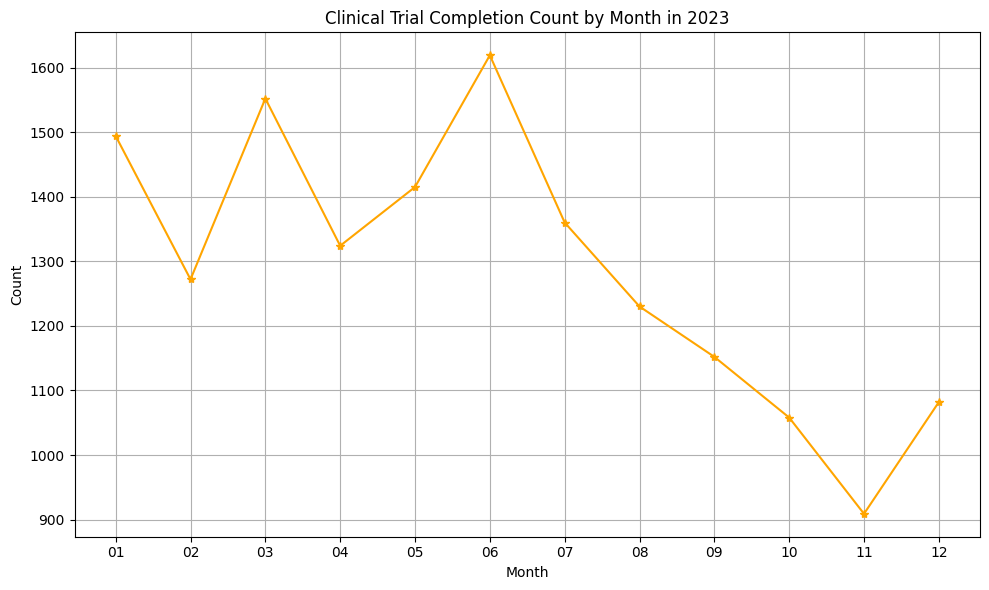

In [0]:
# Q5.1
import matplotlib.pyplot as plt

# Data
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
counts = [1494, 1272, 1552, 1324, 1415, 1619, 1360, 1230, 1152, 1058, 909, 1082]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(months, counts, marker='*', color='orange', linestyle='-')
plt.title('Clinical Trial Completion Count by Month in 2023')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(months)  # Set the x-axis ticks to be the months
plt.grid(True)  # Show gridlines
plt.tight_layout()

# Show plot
plt.show()
